Monolayer unit domain. Piecewise PML. Convergence (eigenvalue error)

In [167]:
try:
    import dolfinx
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenicsx-install-release-complex.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh"
    import dolfinx

In [168]:
import matplotlib.pyplot as plt

try:
	if "science" not in plt.style.available:
		try:
			import scienceplots  # registers styles if installed
		except Exception:
			# Install SciencePlots (registers the 'science' style) and import it
			get_ipython().run_line_magic('pip', 'install -q SciencePlots')
			import scienceplots  # noqa: F401
	plt.style.use(["science", "grid"])
except Exception as e:
	# If anything fails, fall back to a commonly available style
	print("Warning: 'science' style not available. Using 'seaborn' instead. Error:", e)
	plt.style.use("seaborn")

In [169]:
import matplotlib as mpl

mpl.rcParams.update({
    # Tamaño físico
    "figure.figsize": (2.9, 2.6),

    # Líneas
    "lines.linewidth": 2.0,
    "lines.markersize": 8,

    # Fuente de títulos, labels y leyendas
    "font.size": 23,
    "axes.labelsize": 23,
    "axes.titlesize": 23,
    "legend.fontsize": 20,

    # Números de los ejes un pelín más pequeños
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,

    # Ejes y ticks
    "axes.linewidth": 1.4,
    "xtick.major.width": 1.4,
    "ytick.major.width": 1.4,

    # PDF limpio
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
})


In [170]:
# Importing libraries
from matplotlib import ticker
import numpy as np
from mpi4py import MPI
from ufl import (
    inner,
    grad,
    conj,
    TrialFunction,
    TestFunction,
    as_matrix,
    as_vector,
    dot,
    Or,
    Measure,
    conditional,
    SpatialCoordinate,
)
from dolfinx.mesh import locate_entities_boundary, create_interval, locate_entities, create_submesh, meshtags
from dolfinx.fem import FunctionSpace, Function, functionspace, Function, dirichletbc, locate_dofs_topological, petsc, form, assemble_matrix
import basix
from petsc4py.PETSc import ScalarType, KSP
from slepc4py.SLEPc import EPS  
colors_list = ["blue", "green", "red", "magenta", "black", "purple", "orange", "brown", "pink"]


In [171]:
# dolfinx.__version__

Domain, PML, refinement and physical configurations

In [172]:
# Define element size for the mesh refinement
h_i = [0.125,
    0.0625,
    0.0625 / 2,
    0.0625 / 4,]
    # 0.0625 / 8,]


# Domain configuration
Lx = 1 # fluid domain length (without PML)

# Physical configuration
rho_media_1 = 1 # kg/m^3 
vel_media_1 = 1   # m/s

# Define the density and velocity functions  
def rho_function(x):    
    return rho_media_1+x[0]*0
def vel_function(x):    
    return vel_media_1+x[0]*0
 
# PML configuration
pml_thickness = Lx/4
sigma_0 = 2.  #100/Lx
target=-2.5j
# Solver configuration

requested_eigenvalues_number = 50 # Number of eigenvalues to compute

Solver configuration and computing

In [173]:
def get_configured_problem(mesh, degrees, sigma_x, target):
    # Initialize dictionaries
    dof = {}
    solver_dict={}
    V_dict={}
    Q_dict={}

    # Define finite element spaces
    p_fe_type = basix.ufl.element(family="Lagrange", cell=mesh.basix_cell(), degree=degrees[0])
    v_fe_type = basix.ufl.element(family="DG", cell=mesh.basix_cell(), degree=degrees[1], shape=(mesh.geometry.dim,))
    FE = {"p": p_fe_type, "v": v_fe_type}

    # Create a submesh of PML associated cells
    tdim = mesh.topology.dim

    # Identify the fluid cells
    # fluid_cells = locate_entities(mesh, tdim, lambda x: x[0] <= Lx)

    # Create function spaces for mesh and submesh
    Q = functionspace(mesh,FE["p"])
    V = functionspace(mesh, FE["v"])

    # Dictionaries to store the number of dofs
    dof["p"] = Q.dofmap.index_map.size_global
    dof["v"] = V.dofmap.index_map.size_global

    # Boundary conditions application (for pressure)
    bc = []
    facets = locate_entities_boundary(mesh, 0, lambda x: np.isclose(x[0], 0.0))
    o_boundary_dofs = locate_dofs_topological(Q, 0, facets)  # the dimension is related to mesh entity where dofs are located

    # Setting to zero located dofs related to boundaries
    u_d = Function(Q)
    u_d.x.array[:] = 0.0  # Asign Dirichlet condition value
    bc.append(dirichletbc(u_d, o_boundary_dofs))

    facets = locate_entities_boundary(mesh, 0, lambda x: np.isclose(x[0], Lx+pml_thickness))
    o_boundary_dofs = locate_dofs_topological(Q, 0, facets)  # the dimension is related to mesh entity where dofs are located

    # Define the subdomains using a Python function
    TOL = 1e-6
    def pml_domain(x):
        """Returns True for points in (Lx, Lx + pml_thickness]"""
        return x[0] > Lx - TOL

    # Get topology dimension
    tdim = mesh.topology.dim

    # Locate cells in each subdomain
    pml_cells = locate_entities(mesh, tdim, pml_domain)

    # Create a meshtag to mark the subdomains
    num_cells = mesh.topology.index_map(tdim).size_local
    cell_markers = np.ones(num_cells, dtype=np.int32) # Physical domain tag=1
    cell_markers[pml_cells] = 2       # PML domain tag=2

    cell_tags = meshtags(mesh, tdim, np.arange(num_cells, dtype=np.int32), cell_markers)

    # Now you can use these tags for integration measures
    dx = Measure("dx", domain=mesh, subdomain_data=cell_tags)

    # Setting to zero located dofs related to boundaries
    u_d = Function(Q)
    u_d.x.array[:] = 0.0  # Asign Dirichlet condition value
    bc.append(dirichletbc(u_d, o_boundary_dofs))

    # Interpolates the density and velocity functions
    W = functionspace(mesh, ("DG", 0))
    rho = Function(W)
    rho.interpolate(rho_function)
    c = Function(W)
    c.interpolate(vel_function)

    # Spatial Coordinate is updated for the actual mesh
    x = SpatialCoordinate(mesh)

    # Variation formulation definition
    p = TrialFunction(Q)
    v = TrialFunction(V)
    q = TestFunction(Q)
    w = TestFunction(V)

    # Define the variational forms
    a = form(
        [
            [sigma_x(x) / (rho * c**2) * p * conj(q) * dx(2), -1 * inner(v, grad(q)) * dx],
            [inner(grad(p), w) * dx, sigma_x(x) * rho * inner(v, w) * dx(2)],
        ]
    )
    b = form(
        [
            [1.0 / (rho * c**2) * p * conj(q) * dx, None],
            [None, rho * inner(v, w) * dx],
        ]
    )
    # Assemble matrices
    A = petsc.assemble_matrix_block(a, bcs=bc)
    A.assemble()
    B = petsc.assemble_matrix_block(b, bcs=bc)
    B.assemble()

    # SLEPc solver configuration for linear eigenvalue problem (A x =\lambda x B)
    solver = EPS().create()
    solver.setOperators(-A, B)
    solver.setType("arnoldi")
    solver.setWhichEigenpairs(9)  # TARGET_IMAGINARY = 9, TARGET_MAGNITUDE = 7, TARGET_REAL = 8
    solver.setDimensions(
        requested_eigenvalues_number,
        4 * requested_eigenvalues_number,
        4 * requested_eigenvalues_number,
    )
    solver.setTolerances(1e-16, 100)
    st = solver.getST()
    st.setType("sinvert")  # Applying spectral transformation "shift and invert"
    solver.setTarget(target)
    solver.solve()
    n_eigs_converged_quadratic = solver.getConverged()

    return solver, mesh, Q, V, dof

Approx eigenvalues calculation

In [174]:
def get_approx_eigenpair(solver, selected_index, Q, V, dof, exact_value):
    from numpy import abs

    # Gets p, v eigenvectors
    p_h = Function(Q, name="p")
    v_h = Function(V, name="v")
    dof["p"] = Q.dofmap.index_map.size_global
    dof["v"] = V.dofmap.index_map.size_global
    [vrA, viA] = solver.getOperators()[0].getVecs()  # type: ignore

    # Filtrar eigenvalores con parte real maior que 1e-12
    eigenvalues = []
    for i in range(solver.getConverged()):
        omega_value = solver.getEigenpair(i, vrA) * (1j)  # type: ignore
        if omega_value.real > 1e-12:
            eigenvalues.append((omega_value, vrA.copy()))

    if not (0 <= selected_index < len(eigenvalues)):
        raise IndexError("selected_index fóra de rango dos eigenvalores filtrados")

    # Comprobación do máis próximo ao exacto nun rango de ±5
    i_min = max(0, selected_index - 5)
    i_max = min(len(eigenvalues), selected_index + 6)

    closest_idx = min(
        range(i_min, i_max),
        key=lambda i: abs(eigenvalues[i][0] - exact_value)
    )

    if closest_idx != selected_index:
        print(f"Aviso: o índice {selected_index} non é o máis próximo ao valor exacto.")
        print(f"O máis próximo é o índice {closest_idx} con valor {eigenvalues[closest_idx][0]}")
    # else:
        # print("O índice seleccionado é o máis próximo ao valor exacto.")

    # Seleccionar o autovalor e vector correspondente
    omega_value, vrA = eigenvalues[closest_idx]

    # FEM approximation for the eigenfunction
    p_h.x.petsc_vec.array[:] = vrA[0 : dof["p"]]
    p_h.x.petsc_vec.array[:] /= p_h.eval([Lx, 0.0, 0.0], 1)  # normalizar
    v_h.x.petsc_vec.array[:] = vrA[dof["p"] :]  
    v_h.x.petsc_vec.array[:] /= v_h.eval([Lx, 0.0, 0.0], 1)  # normalizar

    return [omega_value, p_h, v_h]


piecewise

In [175]:
get_exact_pml_eigenvalue=lambda n: ((n+1) * np.pi * vel_media_1 - 1j * pml_thickness*sigma_0) / (Lx + pml_thickness)

exact = [None] * 5 
for j in np.arange(0, 5,1):
    exact[j] = get_exact_pml_eigenvalue(j)


In [176]:
# Define piecewise sigma function
sigma_x_piecewise=lambda x: conditional(x[0] > Lx, sigma_0, 0.0)
# Initialize lists to store the approximated eigenpairs
approx_piecewise_P1_P0 = [[0 for _ in range(5)] for _ in range(len(h_i))]
approx_piecewise_P2_P1 = [[0 for _ in range(5)] for _ in range(len(h_i))]
approx_piecewise_P3_P2 = [[0 for _ in range(5)] for _ in range(len(h_i))]
approx_piecewise_P4_P3 = [[0 for _ in range(5)] for _ in range(len(h_i))]

for i,h in enumerate(h_i):
    # Create mesh depending on h
    mesh = create_interval(MPI.COMM_WORLD, int((Lx + pml_thickness )/ h), [0, Lx + pml_thickness])
    # Define solver for piecewise PML
    [solver_piecewise_P1_P0, mesh, Q_P1_P0, V_P1_P0, dof_P1_P0]=get_configured_problem(mesh, [1,0], sigma_x_piecewise, target)
    [solver_piecewise_P2_P1, mesh, Q_P2_P1, V_P2_P1, dof_P2_P1]=get_configured_problem(mesh, [2,1], sigma_x_piecewise, target)
    [solver_piecewise_P3_P2, mesh, Q_P3_P2, V_P3_P2, dof_P3_P2]=get_configured_problem(mesh, [3,2], sigma_x_piecewise, target)
    [solver_piecewise_P4_P3, mesh, Q_P4_P3, V_P4_P3, dof_P4_P3]=get_configured_problem(mesh, [4,3], sigma_x_piecewise, target)

    for j in np.arange(0, 5,1):
        # Get the approximated eigenpair
        approx_piecewise_P1_P0[i][j] = get_approx_eigenpair(solver_piecewise_P1_P0, j, Q_P1_P0, V_P1_P0, dof_P1_P0, exact[j])[0]
        approx_piecewise_P2_P1[i][j] = get_approx_eigenpair(solver_piecewise_P2_P1, j, Q_P2_P1, V_P2_P1, dof_P2_P1, exact[j])[0]
        approx_piecewise_P3_P2[i][j] = get_approx_eigenpair(solver_piecewise_P3_P2, j, Q_P3_P2, V_P3_P2, dof_P3_P2, exact[j])[0]
        approx_piecewise_P4_P3[i][j] = get_approx_eigenpair(solver_piecewise_P4_P3, j, Q_P4_P3, V_P4_P3, dof_P4_P3, exact[j])[0]


In [177]:
def agrupar_por_posicion(lista_de_listas):
    return [list(grupo) for grupo in zip(*lista_de_listas)]

def borrar_filas_incompletas(lista_de_listas, longitud_minima):
    return [fila for fila in lista_de_listas if len(fila) >= longitud_minima]

# Uso de la función
longitud_minima = len(h_i)
groups_P1_P0=agrupar_por_posicion(approx_piecewise_P1_P0)
groups_P2_P1=agrupar_por_posicion(approx_piecewise_P2_P1)
groups_P3_P2=agrupar_por_posicion(approx_piecewise_P3_P2)
groups_P4_P3=agrupar_por_posicion(approx_piecewise_P4_P3)

groups_P1_P0 = borrar_filas_incompletas(groups_P1_P0, longitud_minima)
groups_P2_P1 = borrar_filas_incompletas(groups_P2_P1, longitud_minima)
groups_P3_P2 = borrar_filas_incompletas(groups_P3_P2, longitud_minima)
groups_P4_P3 = borrar_filas_incompletas(groups_P4_P3, longitud_minima)

In [178]:
rel_error_eig_0_P1_P0=abs((groups_P1_P0[0] - exact[0])) / np.abs(exact[0]) *100
rel_error_eig_1_P1_P0=abs((groups_P1_P0[1] - exact[1])) / np.abs(exact[1]) *100
rel_error_eig_2_P1_P0=abs((groups_P1_P0[2] - exact[2])) / np.abs(exact[2]) *100
rel_error_eig_3_P1_P0=abs((groups_P1_P0[3] - exact[3])) / np.abs(exact[3]) *100

rel_error_eig_0_P2_P1=abs((groups_P2_P1[0] - exact[0])) / np.abs(exact[0]) *100
rel_error_eig_1_P2_P1=abs((groups_P2_P1[1] - exact[1])) / np.abs(exact[1]) *100
rel_error_eig_2_P2_P1=abs((groups_P2_P1[2] - exact[2])) / np.abs(exact[2]) *100
rel_error_eig_3_P2_P1=abs((groups_P2_P1[3] - exact[3])) / np.abs(exact[3]) *100

rel_error_eig_0_P3_P2=abs((groups_P3_P2[0] - exact[0])) / np.abs(exact[0]) *100
rel_error_eig_1_P3_P2=abs((groups_P3_P2[1] - exact[1])) / np.abs(exact[1]) *100
rel_error_eig_2_P3_P2=abs((groups_P3_P2[2] - exact[2])) / np.abs(exact[2]) *100
rel_error_eig_3_P3_P2=abs((groups_P3_P2[3] - exact[3])) / np.abs(exact[3]) *100

rel_error_eig_0_P4_P3=abs((groups_P4_P3[0] - exact[0])) / np.abs(exact[0]) *100
rel_error_eig_1_P4_P3=abs((groups_P4_P3[1] - exact[1])) / np.abs(exact[1]) *100
rel_error_eig_2_P4_P3=abs((groups_P4_P3[2] - exact[2])) / np.abs(exact[2]) *100
rel_error_eig_3_P4_P3=abs((groups_P4_P3[3] - exact[3])) / np.abs(exact[3]) *100


In [179]:
print("P1-P0:")
for idx in range(5):
    print(f"Autovalor {idx}:")
    print(f"  Exacto:      {exact[idx]}")
    print(f"  Aproximado:  {groups_P1_P0[idx][-1]}")
    error = abs(groups_P1_P0[idx][-1] - exact[idx]) / abs(exact[idx])
    print(f"  Error rel.:  {error}\n")

P1-P0:
Autovalor 0:
  Exacto:      (2.5132741228718345-0.4j)
  Aproximado:  (2.513410194310077-0.40005716596094804j)
  Error rel.:  5.799504810915964e-05

Autovalor 1:
  Exacto:      (5.026548245743669-0.4j)
  Aproximado:  (5.027691079575665-0.40007915976090347j)
  Error rel.:  0.00022718612663681366

Autovalor 2:
  Exacto:      (7.5398223686155035-0.4j)
  Aproximado:  (7.5439405578238645-0.399917996966127j)
  Error rel.:  0.0005455329247709495

Autovalor 3:
  Exacto:      (10.053096491487338-0.4j)
  Aproximado:  (10.063272246325914-0.3997959044222095j)
  Error rel.:  0.0010116041870063175

Autovalor 4:
  Exacto:      (12.566370614359172-0.4j)
  Aproximado:  (12.586505457759934-0.3999988284529582j)
  Error rel.:  0.0016014688223393138



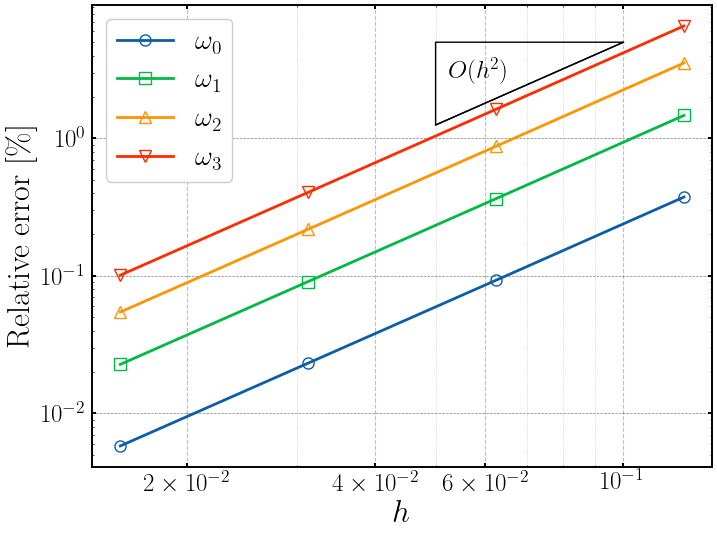

In [180]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
from matplotlib.patches import Polygon

h_i = np.array(h_i)
fig, ax = plt.subplots(figsize=(8,6))

# Ploteo
ax.plot(h_i, rel_error_eig_0_P1_P0, "o-", mfc='none', label='$\omega_0$')
ax.plot(h_i, rel_error_eig_1_P1_P0, "s-", mfc='none', label='$\omega_1$')
ax.plot(h_i, rel_error_eig_2_P1_P0, "^-", mfc='none', label='$\omega_2$')
ax.plot(h_i, rel_error_eig_3_P1_P0, "v-", mfc='none', label='$\omega_3$')




# Punto del ángulo recto (arriba izquierda)
x0 = 5e-2
y0 = 5

dx = 2.0      # factor horizontal
order = 2     # O(h^2)

# Vértices:
# A = ángulo recto (arriba izquierda)
# B = derecha (horizontal)
# C = abajo (vertical)
triangle = np.array([
    [x0, y0],                 # A
    [x0*dx, y0],              # B → horizontal
    [x0, y0/(dx**order)]      # C ↓ vertical
])

poly = Polygon(triangle, fill=False, edgecolor="k", lw=1)
ax.add_patch(poly)

# Hipotenusa (opcional remarcarla)
ax.plot(
    [x0*dx, x0],
    [y0, y0/(dx**order)],
    color="k", lw=1
)

# Etiqueta
ax.text(x0*1.05, 1.1*y0/(dx**order/2), r"$O(h^2)$", fontsize=18)


# Escalas log
ax.set_xscale("log")
ax.set_yscale("log")

# Formatear eje x con notación científica horizontal
# ax.xaxis.set_major_formatter(mticker.LogFormatterSciNotation(base=10))
# Grid: líneas verticales en ticks mayores y menores
ax.grid(which='major', axis='x', linestyle='--', color='gray', linewidth=0.8)
ax.grid(which='minor', axis='x', linestyle=':', color='gray', linewidth=0.5)  # menores más finas


# Grid opcional
# ax.grid(True, which='both', axis='y', linestyle=':')  # verticales ya hechas con axvline

ax.set_xticks([2e-2, 4e-2, 6e-2, 1e-1])
ax.xaxis.set_minor_formatter(mticker.NullFormatter())
ax.set_xlabel("$h$")
ax.set_ylabel("Relative error [\%]")
ax.legend()
plt.savefig("FIG_Single_Constant_P1P0.pdf",bbox_inches="tight")

plt.show()

In [181]:
print("P2-P1:")
for idx in range(5):
    print(f"Autovalor {idx}:")
    print(f"  Exacto:      {exact[idx]}")
    print(f"  Aproximado:  {groups_P2_P1[idx][-1]}")
    error = abs(groups_P2_P1[idx][-1] - exact[idx]) / abs(exact[idx])
    print(f"  Error rel.:  {error}\n")

P2-P1:
Autovalor 0:
  Exacto:      (2.5132741228718345-0.4j)
  Aproximado:  (2.5132741213436605-0.4000000005109554j)
  Error rel.:  6.331597754589622e-10

Autovalor 1:
  Exacto:      (5.026548245743669-0.4j)
  Aproximado:  (5.026548352724861-0.399999991536147j)
  Error rel.:  2.128245635444185e-08

Autovalor 2:
  Exacto:      (7.5398223686155035-0.4j)
  Aproximado:  (7.5398233151636935-0.4000000513284842j)
  Error rel.:  1.2554774509043242e-07

Autovalor 3:
  Exacto:      (10.053096491487338-0.4j)
  Aproximado:  (10.053100464994802-0.400000206768307j)
  Error rel.:  3.9547394837668906e-07

Autovalor 4:
  Exacto:      (12.566370614359172-0.4j)
  Aproximado:  (12.566382807333978-0.40000008342171517j)
  Error rel.:  9.69817624003665e-07



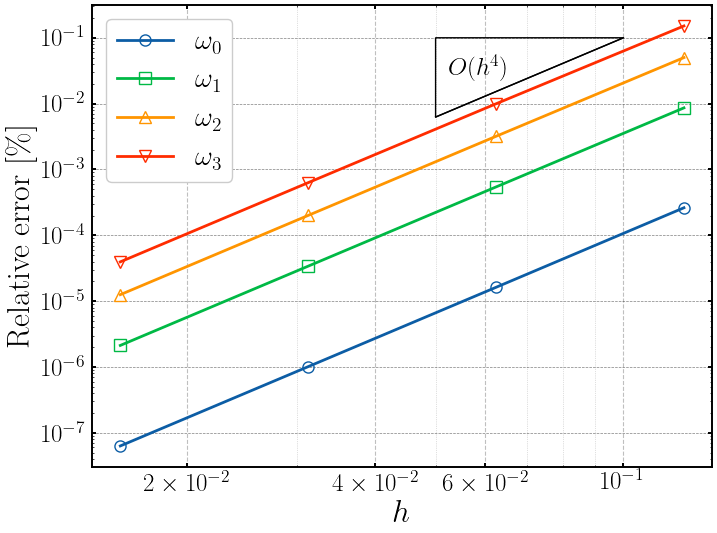

In [182]:
fig, ax = plt.subplots(figsize=(8,6))

# Ploteo
ax.plot(h_i, rel_error_eig_0_P2_P1, "o-", mfc='none', label='$\omega_0$')
ax.plot(h_i, rel_error_eig_1_P2_P1, "s-", mfc='none', label='$\omega_1$')
ax.plot(h_i, rel_error_eig_2_P2_P1, "^-", mfc='none', label='$\omega_2$')
ax.plot(h_i, rel_error_eig_3_P2_P1, "v-", mfc='none', label='$\omega_3$')

# Escalas log
ax.set_xscale("log")
ax.set_yscale("log")

# Formatear eje x con notación científica horizontal
ax.xaxis.set_major_formatter(mticker.LogFormatterSciNotation(base=10))
# Grid: líneas verticales en ticks mayores y menores
ax.grid(which='major', axis='x', linestyle='--', color='gray', linewidth=0.8)
ax.grid(which='minor', axis='x', linestyle=':', color='gray', linewidth=0.5)  # menores más finas


# Punto del ángulo recto (arriba izquierda)
x0 = 5e-2
y0 = 1e-1

dx = 2.0      # factor horizontal
order = 4     # O(h^4)

# Vértices:
# A = ángulo recto (arriba izquierda)
# B = derecha (horizontal)
# C = abajo (vertical)
triangle = np.array([
    [x0, y0],                 # A
    [x0*dx, y0],              # B → horizontal
    [x0, y0/(dx**order)]      # C ↓ vertical
])

poly = Polygon(triangle, fill=False, edgecolor="k", lw=1)
ax.add_patch(poly)

# Hipotenusa (opcional remarcarla)
ax.plot(
    [x0*dx, x0],
    [y0, y0/(dx**order)],
    color="k", lw=1
)

# Etiqueta
ax.text(x0*1.05, 2.2*y0/(dx**order/2), r"$O(h^4)$", fontsize=18)

ax.set_xticks([2e-2, 4e-2, 6e-2, 1e-1])
ax.xaxis.set_minor_formatter(mticker.NullFormatter())
# Etiquetas y grid
ax.set_xlabel("$h$")
ax.set_ylabel("Relative error [\%]")
ax.grid(True)
ax.legend()
plt.savefig("FIG_Single_Constant_P2P1.pdf",bbox_inches="tight")
plt.show()


In [183]:
print("P3-P2:")
for idx in range(5):
    print(f"Autovalor {idx}:")
    print(f"  Exacto:      {exact[idx]}")
    print(f"  Aproximado:  {groups_P3_P2[idx][-1]}")
    error = abs(groups_P3_P2[idx][-1] - exact[idx]) / abs(exact[idx])
    print(f"  Error rel.:  {error}\n")

P3-P2:
Autovalor 0:
  Exacto:      (2.5132741228718345-0.4j)
  Aproximado:  (2.51327412287521-0.399999999999787j)
  Error rel.:  1.3290217389874142e-12

Autovalor 1:
  Exacto:      (5.026548245743669-0.4j)
  Aproximado:  (5.026548245749743-0.4000000000024534j)
  Error rel.:  1.299172484363203e-12

Autovalor 2:
  Exacto:      (7.5398223686155035-0.4j)
  Aproximado:  (7.53982236868809-0.40000000000282154j)
  Error rel.:  9.620808932339384e-12

Autovalor 3:
  Exacto:      (10.053096491487338-0.4j)
  Aproximado:  (10.053096492138263-0.39999999997443825j)
  Error rel.:  6.47473462742471e-11

Autovalor 4:
  Exacto:      (12.566370614359172-0.4j)
  Aproximado:  (12.566370617725093-0.40000000002497604j)
  Error rel.:  2.6772325073117553e-10



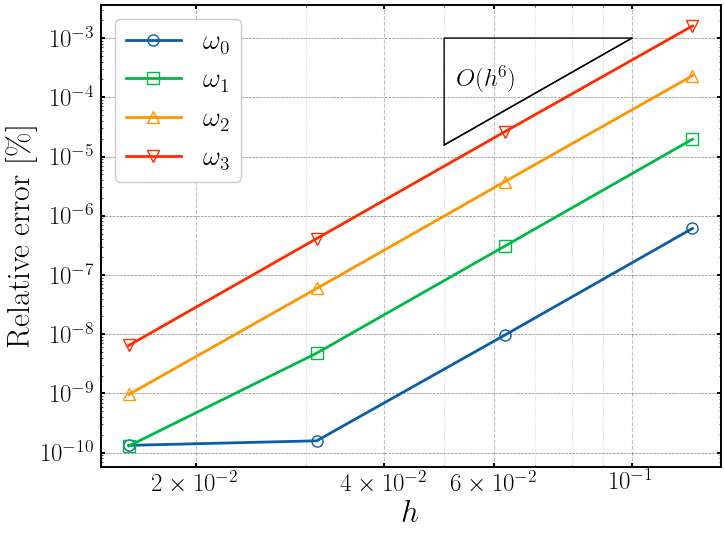

In [184]:
fig, ax = plt.subplots(figsize=(8,6))

# Ploteo
ax.plot(h_i, rel_error_eig_0_P3_P2, "o-", mfc='none', label='$\omega_0$')
ax.plot(h_i, rel_error_eig_1_P3_P2, "s-", mfc='none', label='$\omega_1$')
ax.plot(h_i, rel_error_eig_2_P3_P2, "^-", mfc='none', label='$\omega_2$')
ax.plot(h_i, rel_error_eig_3_P3_P2, "v-", mfc='none', label='$\omega_3$')
# Escalas log
ax.set_xscale("log")
ax.set_yscale("log")

# Formatear eje x con notación científica horizontal
ax.xaxis.set_major_formatter(mticker.LogFormatterSciNotation(base=10))
# Grid: líneas verticales en ticks mayores y menores
ax.grid(which='major', axis='x', linestyle='--', color='gray', linewidth=0.8)
ax.grid(which='minor', axis='x', linestyle=':', color='gray', linewidth=0.5)  # menores más finas

# Punto del ángulo recto (arriba izquierda)
x0 = 5e-2
y0 = 1e-3

dx = 2.0      # factor horizontal
order = 6     # O(h^6)

# Vértices:
# A = ángulo recto (arriba izquierda)
# B = derecha (horizontal)
# C = abajo (vertical)
triangle = np.array([
    [x0, y0],                 # A
    [x0*dx, y0],              # B → horizontal
    [x0, y0/(dx**order)]      # C ↓ vertical
])

poly = Polygon(triangle, fill=False, edgecolor="k", lw=1)
ax.add_patch(poly)

# Hipotenusa (opcional remarcarla)
ax.plot(
    [x0*dx, x0],
    [y0, y0/(dx**order)],
    color="k", lw=1
)

# Etiqueta
ax.text(x0*1.05, 5*y0/(dx**order/2), r"$O(h^6)$", fontsize=18)

ax.set_xticks([2e-2, 4e-2, 6e-2, 1e-1])
ax.xaxis.set_minor_formatter(mticker.NullFormatter())
# Etiquetas y grid
ax.set_xlabel("$h$")
ax.set_ylabel("Relative error [\%]")
ax.grid(True)
ax.legend()
plt.savefig("FIG_Single_Constant_P3P2.pdf",bbox_inches="tight")
plt.show()


In [185]:
print("P4-P3:")
for idx in range(5):
    print(f"Autovalor {idx}:")
    print(f"  Exacto:      {exact[idx]}")
    print(f"  Aproximado:  {groups_P4_P3[idx][-1]}")
    error = abs(groups_P4_P3[idx][-1] - exact[idx]) / abs(exact[idx])
    print(f"  Error rel.:  {error}\n")

P4-P3:
Autovalor 0:
  Exacto:      (2.5132741228718345-0.4j)
  Aproximado:  (2.513274122872805-0.3999999999998174j)
  Error rel.:  3.8797988987214096e-13

Autovalor 1:
  Exacto:      (5.026548245743669-0.4j)
  Aproximado:  (5.02654824574437-0.39999999999953495j)
  Error rel.:  1.6679544399218767e-13

Autovalor 2:
  Exacto:      (7.5398223686155035-0.4j)
  Aproximado:  (7.539822368616198-0.3999999999991912j)
  Error rel.:  1.411968184855984e-13

Autovalor 3:
  Exacto:      (10.053096491487338-0.4j)
  Aproximado:  (10.053096491488171-0.3999999999991161j)
  Error rel.:  1.2072738224224938e-13

Autovalor 4:
  Exacto:      (12.566370614359172-0.4j)
  Aproximado:  (12.566370614360567-0.39999999999928965j)
  Error rel.:  1.2447246122423093e-13



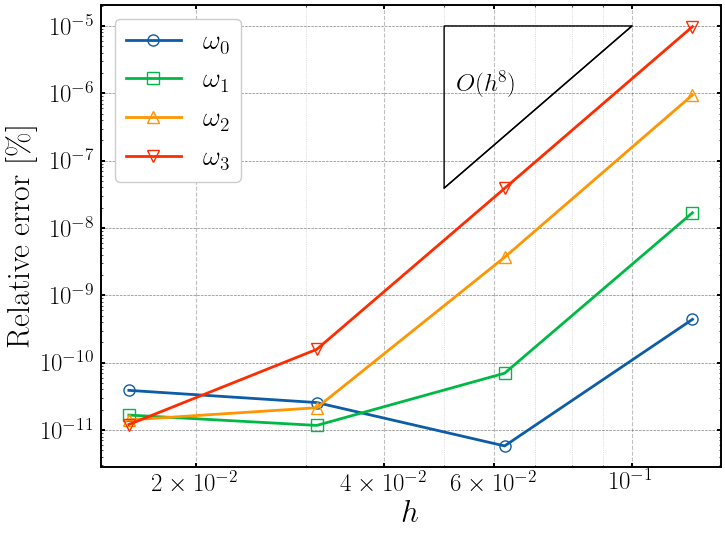

In [186]:
fig, ax = plt.subplots(figsize=(8,6))

# Ploteo
ax.plot(h_i, rel_error_eig_0_P4_P3, "o-", mfc='none', label='$\omega_0$')
ax.plot(h_i, rel_error_eig_1_P4_P3, "s-", mfc='none', label='$\omega_1$')
ax.plot(h_i, rel_error_eig_2_P4_P3, "^-", mfc='none', label='$\omega_2$')
ax.plot(h_i, rel_error_eig_3_P4_P3, "v-", mfc='none', label='$\omega_3$')
# Escalas log
ax.set_xscale("log")
ax.set_yscale("log")

# Formatear eje x con notación científica horizontal
ax.xaxis.set_major_formatter(mticker.LogFormatterSciNotation(base=10))
# Grid: líneas verticales en ticks mayores y menores
ax.grid(which='major', axis='x', linestyle='--', color='gray', linewidth=0.8)
ax.grid(which='minor', axis='x', linestyle=':', color='gray', linewidth=0.5)  # menores más finas

# Punto del ángulo recto (arriba izquierda)
x0 = 5e-2
y0 = 1e-5

dx = 2.0      # factor horizontal
order = 8     # O(h^8)

# Vértices:
# A = ángulo recto (arriba izquierda)
# B = derecha (horizontal)
# C = abajo (vertical)
triangle = np.array([
    [x0, y0],                 # A
    [x0*dx, y0],              # B → horizontal
    [x0, y0/(dx**order)]      # C ↓ vertical
])

poly = Polygon(triangle, fill=False, edgecolor="k", lw=1)
ax.add_patch(poly)

# Hipotenusa (opcional remarcarla)
ax.plot(
    [x0*dx, x0],
    [y0, y0/(dx**order)],
    color="k", lw=1
)

# Etiqueta
ax.text(x0*1.05, 14*y0/(dx**order/2), r"$O(h^8)$", fontsize=18)

ax.set_xticks([2e-2, 4e-2, 6e-2, 1e-1])
ax.xaxis.set_minor_formatter(mticker.NullFormatter())
# Etiquetas y grid
ax.set_xlabel("$h$")
ax.set_ylabel("Relative error [\%]")
ax.grid(True)
ax.legend(loc='upper left')
plt.savefig("FIG_Single_Constant_P4P3.pdf",bbox_inches="tight")
plt.show()
